量子ソフトウェア勉強会:「量子インスパイアード古典アルゴリズム」ハンズオン資料 1  
2023年9月20日(水)  
高比良宗一 (名城大学情報工学部情報工学科)

# $\mathrm{SQ}(A)$と$\mathrm{SQ}(b)$の実装について
このノートブックでは，SQデータ構造を実装します．
最初にセグメント木構造を実装します．次に，それを用いてベクトルに基づくデータ構造$\mathrm{SQ}(v)$を実装します．その後に行列に基づくデータ構造$\mathrm{SQ}(A)$を，ベクトルに基づくデータ構造を用いて実装します．
$$
%  ![image.png](attachment:image.png)
\newcommand{\abs}[1]{|#1|}
\newcommand{\norm}[1]{\lVert#1\rVert}
$$

In [125]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# セグメント木構造の実装
[セグメント木構造](https://en.wikipedia.org/wiki/Segment_tree)は，次のセルのように実装できます．

In [126]:
class SegmentTree:
    def __init__(self, n):
        self.size   = 2**(math.ceil(math.log2(n)) + 1)
        self.height = math.ceil(math.log2(n))
        self.data   = np.zeros(self.size)

    def root(self):
        return self.data[1] 
               
    def leaf(self, i):
        index = self.size//2 + i
        return self.data[index]
    
    def update(self, k, val):
        size = self.size
        for _ in (range(self.height+1)):
            size = size//2
            self.data[size + k] += val
            k = k // 2 
            
    def __str__(self):
        return str(self.data)

# ベクトルに関するデータ構造 $\mathrm{SQ}(v)$ の実装
セグメント木構造を用いて，ベクトルに基づいたデータ構造$\mathrm{SQ}(v)$を実装します．簡単のために実ベクトルのみを扱います．

## 定義
$\mathrm{SQ}(v)$の定義は下記の通りです．

ベクトル$v \in \mathbb{C}^n$に対して，$\mathrm{SQ}(v)$を次の操作(1-3)が行えるようなデータ構造とする．([2.](https://dl.acm.org/doi/10.1145/3357713.3384314)のDefinition 2.5や[3.](https://quantum-journal.org/papers/q-2022-06-30-754/)のDefinition 1.1など)
- $\text{Sample}()$.  確率$\abs{v_i}^2/\norm{v}^2$で添字$i$を出力する
- $\text{Query}(i)$. ベクトルの第$i$成分を出力する
- $\text{Norm}()$. ベクトルの2ノルム$\norm{v}$を出力する  

## 実装

In [127]:
class VectorBasedDataStructure:    
    def __init__(self, vector):
        self.n = vector.size
        self.segment_tree = SegmentTree(self.n)
        self.sgn = np.sign(vector)
        for i in range(self.n):
            self.segment_tree.update(i, abs(vector[i])**2)
            
    def sample(self):
        return self._sample2()
                            
    def _sample1(self):
        height = self.segment_tree.height    
        size   = self.segment_tree.size
        k = 1
        for _ in range(height):
            if random.random() < self.segment_tree.data[2*k]/self.segment_tree.data[k]:
                k = 2*k
            else:
                k = 2*k+1
        return k - size//2
    
    def _sample2(self):
        height = self.segment_tree.height    
        size   = self.segment_tree.size
        k = 1
        for _ in range(height):
            if random.random()*self.segment_tree.data[k] < self.segment_tree.data[2*k]:
                k = 2*k
            else:
                k = 2*k+1
        return k - size//2    
    
    def query(self, i):
        val = self.segment_tree.leaf(i)
        return self.sgn[i]*math.sqrt(val)    
            
    def norm(self):
        return math.sqrt(self.segment_tree.root())
    
    def print_structure(self):
        data = self.segment_tree.data
        height = self.segment_tree.height
        print("height =", height)
        k = 1
        for i in range(height+1):
            lst = []
            for j in range(2**i,2**(i+1)):  
                lst.append(data[j])
            print(lst)   
        print(self.sgn)

## 確認
上のセルの`VectorBasedDataStructure`が$\mathrm{SQ}(v)$を実装できているか確認します．
各関数$\mathrm{Norm}(), \mathrm{Query}(i), \mathrm{Sample}()$それぞれについて確認していきます．

In [128]:
import numpy as np
n = 10
v = np.random.rand(n) - np.random.rand(n)
SQv = VectorBasedDataStructure(v)

In [129]:
SQv.print_structure()

height = 4
[2.448569350113205]
[1.8257522517986355, 0.6228170983145696]
[1.4081692953908433, 0.417582956407792, 0.6228170983145696, 0.0]
[0.9040148948790538, 0.5041544005117894, 0.18858400987600943, 0.2289989465317826, 0.6228170983145696, 0.0, 0.0, 0.0]
[0.5134774824972979, 0.390537412381756, 0.5012377704182622, 0.0029166300935271807, 0.1416840701326077, 0.046899939743401745, 0.2107787982003918, 0.018220148331390806, 0.4618647517187302, 0.16095234659583932, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-1. -1. -1. -1.  1. -1. -1. -1. -1.  1.]


### $\mathrm{Norm}()$について
ベクトルの2ノルムが計算できているかどうか，NumPyの結果と比較をして確認してみます．

In [130]:
val = SQv.norm()
normv = np.linalg.norm(v, 2)

print(f"SQv.norm() = {val},\nnumpy.linalg.norm(v) = {normv}")

SQv.norm() = 1.5647905131720363,
numpy.linalg.norm(v) = 1.5647905131720363


### $\mathrm{Query}(i)$について
全ての$i$に対して，元々のベクトル$v$の$i$番目の成分と比較をしてみます．

In [131]:
for i in range(n):
    val = SQv.query(i) 
    vi  = v[i]
    print(f"SQv.query({i}) = {val}, v_{i} = {vi}")
    
test_vector = np.array([SQv.query(i) for i in range(n)])
np.allclose(test_vector, v)

SQv.query(0) = -0.7165734313364527, v_0 = -0.7165734313364527
SQv.query(1) = -0.6249299259771098, v_1 = -0.6249299259771098
SQv.query(2) = -0.7079814760417551, v_2 = -0.7079814760417551
SQv.query(3) = -0.05400583388419422, v_3 = -0.05400583388419422
SQv.query(4) = 0.37640944479729477, v_4 = 0.37640944479729477
SQv.query(5) = -0.21656393915747318, v_5 = -0.21656393915747318
SQv.query(6) = -0.4591065216269442, v_6 = -0.4591065216269442
SQv.query(7) = -0.13498202966095452, v_7 = -0.13498202966095452
SQv.query(8) = -0.6796063211291742, v_8 = -0.6796063211291742
SQv.query(9) = 0.4011886670830064, v_9 = 0.4011886670830064


True

### $\mathrm{Sample}()$について
`SQv.sample()`を何度も実行して得られた結果と，真の確率分布$\mathcal{D}_v (\Pr(i) = |v_i|^2/\norm{v}^2)$とを比較します．

SQ(v) [0.2141 0.162  0.2029 0.0014 0.0574 0.0196 0.089  0.008  0.183  0.0626]
exact [0.2097051  0.15949616 0.20470638 0.00119116 0.05786402 0.01915402
 0.08608243 0.00744114 0.18862637 0.06573322]
error = 0.008922043102418013


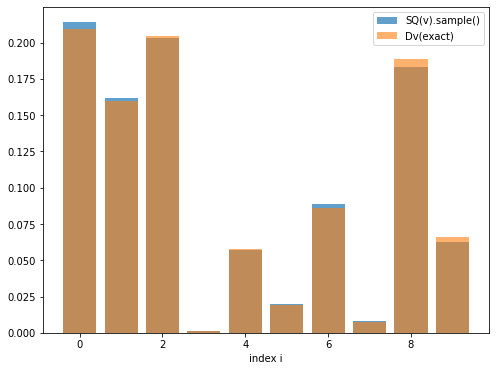

In [132]:
normv = np.linalg.norm(v, 2)
Dv = np.array([abs(v[i])**2/normv**2 for i in range(n)])

counts = np.zeros(n)

sample_size = 10000
for _ in range(sample_size):
    i = SQv.sample() 
    counts[i] += 1

print("SQ(v)", counts/sample_size)
print("exact", Dv)

print("error =", np.linalg.norm(Dv - counts/sample_size))

plt.figure(figsize=(8,6))
plt.bar(range(n), counts/sample_size, alpha=0.7, label="SQ(v).sample()")
plt.bar(range(n), Dv                , alpha=0.6, label="Dv(exact)")

plt.legend()
plt.xlabel("index i")
plt.show()

グラフの青色は$\mathrm{SQ}(v)$の結果を表し，オレンジ色は真の分布$\mathcal{D}_v$を表します．視覚的に見て大体同じであることを確認できると思います．

# 行列に基づくデータ構造 $\mathrm{SQ}(A)$ の実装
$\mathrm{SQ}(v)$について実装しました．これを用いて$\mathrm{SQ}(A)$を実装します．
簡単のために実行列のみを扱います．

## 定義

行列$A \in \mathbb{C}^{m \times n}$に対して，$\mathrm{SQ}(A)$を次の操作(1-5)が行えるようなデータ構造とする．([2.](https://dl.acm.org/doi/10.1145/3357713.3384314)のDefinition 2.10や[3.](https://quantum-journal.org/papers/q-2022-06-30-754/)のDefinition 1.2など)
- $\text{Sample1}()$. 確率$\norm{A_{i,\ast}}^2/\norm{A}_\mathrm{F}^2$で行添字$i$を出力する
- $\text{Sample2}(i)$. 確率$\abs{A_{ij}}^2/\norm{A_{i,\ast}}^2$で列添字$j$を出力する
- $\text{Query}(i,j)$.  第$(i,j)$成分$A_{ij}$を出力する
- $\text{Norm}(i)$. 第$i$行の2ノルム$\norm{A_{i,\ast}}$を出力する
- $\text{Norm}()$.  フロべニウスノルム$\norm{A}_\mathrm{F}$を出力する


## 実装
`VectorBasedDataStructure`を用いて$\mathrm{SQ(A)}$を実装します．

In [133]:
class MatrixBasedDataStructure:
    def __init__(self, matrix):
        self.m, self.n = matrix.shape
        self.shape = matrix.shape
        
        self.vecFro = np.array([np.linalg.norm(matrix[i,:]) for i in range(self.m)])
        self.SQvecFro = VectorBasedDataStructure(self.vecFro)
        self.SQrowlist = [VectorBasedDataStructure(matrix[i,:]) for i in range(self.m)]
            

    def sample1(self):
        return self.SQvecFro.sample()

    def sample2(self, i):
        return self.SQrowlist[i].sample()
    
    def query(self, i, j):
        return self.SQrowlist[i].query(j)
    
    def norm(self, i):
        return self.SQrowlist[i].norm()
    
    def normF(self):
        return self.SQvecFro.norm()

## 確認

上のセルの`MatrixBasedDataStructure`が$\mathrm{SQ}(A)$を実装できているか確認します．
各関数$\mathrm{Sample1}()$, $\mathrm{Sample2}()$, $\mathrm{Query}()$, $\mathrm{Norm}(i)$, $\mathrm{Norm}()$ (`normF`), それぞれ確認していきます．

In [134]:
m, n = 8, 16
A = np.random.rand(m, n) - np.random.rand(m, n)
SQA = MatrixBasedDataStructure(A)

### $\mathrm{Sample1}()$について
`SQA.sample1()`を何度も実行して得られた結果と，真の確率分布$\Pr(i) = \norm{A_{i,\ast}}^2/\norm{A}_\mathrm{F}^2$とを比較します．

SQ(A).sample1()
 [0.1522 0.1526 0.0841 0.032  0.1664 0.1372 0.1672 0.1083]
exact
 [0.14825435 0.15554245 0.08303897 0.03323757 0.16950496 0.1370892
 0.16827819 0.10505432]
error = 0.006945032299413305


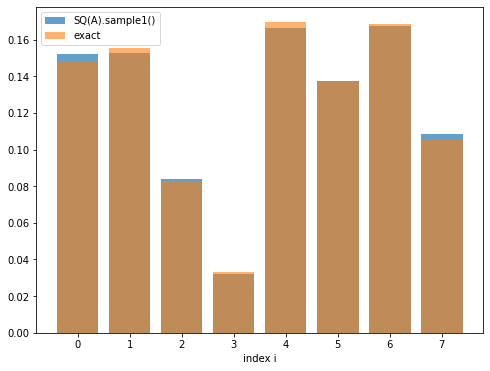

In [135]:
normAF = np.linalg.norm(A) # Aのフロべニウスノルム
Da = np.array([np.linalg.norm(A[i,:])**2/normAF**2 for i in range(m)])

sample_size = 10000
counts = np.zeros(m)
for _ in range(sample_size):
    i = SQA.sample1()
    counts[i] += 1

print("SQ(A).sample1()\n", counts/sample_size)
print("exact\n", Da)
print("error =", np.linalg.norm(Da - counts/sample_size))

plt.figure(figsize=(8,6))

plt.bar(range(m), counts/sample_size, alpha=0.7, label="SQ(A).sample1()")
plt.bar(range(m), Da,                 alpha=0.6, label="exact")

plt.legend()
plt.xlabel("index i")
plt.show()

### $\mathrm{Sample2}(i)$について
$\mathrm{Sample2}(i)$について確認します．$i = 0,1,2,\dots,m-1$の全てを調査すると図がたくさん表示されるので，
図については$i=0,1,2$までを見ます．
`SQA.sample2()`を何度も実行して得られた結果と，真の確率分布$\Pr(j) = |A_{i,j}|^2/\norm{A_{i,\ast}}^2)$とを比較します．

--------- i = 0 ----------
SQ(A).sample2(0):
 [0.009 0.131 0.1   0.001 0.066 0.026 0.01  0.02  0.006 0.012 0.178 0.061
 0.173 0.    0.132 0.075]
exact:
 [6.67122278e-03 1.38546480e-01 7.76453219e-02 2.50954261e-03
 6.44932654e-02 2.45554475e-02 1.28339181e-02 1.72999979e-02
 5.34582623e-03 1.68245798e-02 1.62068438e-01 6.26758781e-02
 1.98143792e-01 6.71504133e-07 1.36248853e-01 7.41367652e-02]
error = 0.038928099973546876


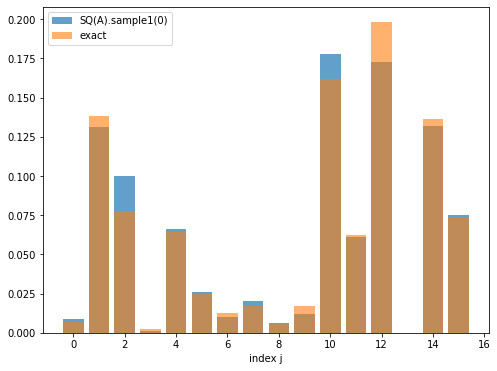

--------- i = 1 ----------
SQ(A).sample2(1):
 [0.213 0.011 0.013 0.001 0.095 0.055 0.003 0.    0.172 0.11  0.    0.084
 0.015 0.192 0.002 0.034]
exact:
 [2.15359578e-01 1.16837036e-02 9.31491496e-03 5.06239791e-03
 7.80504864e-02 4.90597131e-02 5.19151565e-03 2.48252261e-06
 1.69286768e-01 1.21914890e-01 4.32025218e-05 1.00895384e-01
 1.23973871e-02 1.88623411e-01 3.99739544e-03 2.91167693e-02]
error = 0.029056605818409322


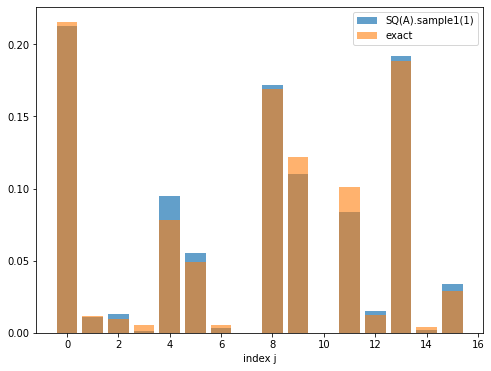

--------- i = 2 ----------
SQ(A).sample2(2):
 [0.023 0.061 0.019 0.139 0.077 0.022 0.056 0.077 0.    0.027 0.105 0.
 0.027 0.    0.111 0.256]
exact:
 [1.57269980e-02 7.35258294e-02 1.89341155e-02 1.26425068e-01
 8.75346716e-02 1.25606000e-02 6.36604968e-02 9.08985281e-02
 7.63685414e-04 2.50247356e-02 1.04376861e-01 2.50924759e-04
 3.29819512e-02 2.76470713e-05 1.09891470e-01 2.37416418e-01]
error = 0.034744195213902936


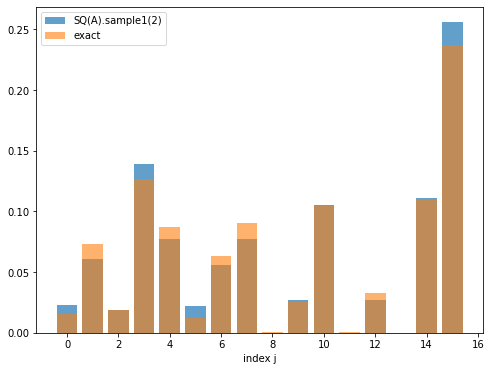

--------- i = 3 ----------
SQ(A).sample2(3):
 [0.154 0.002 0.018 0.055 0.03  0.019 0.143 0.019 0.18  0.038 0.045 0.008
 0.    0.154 0.135 0.   ]
exact:
 [1.69432833e-01 1.60980102e-03 1.10291568e-02 5.21402355e-02
 3.43614356e-02 1.78829232e-02 1.56175123e-01 1.28661022e-02
 1.77819918e-01 3.81903573e-02 3.70157725e-02 1.25719260e-02
 1.25468382e-04 1.56160672e-01 1.22569680e-01 4.85963581e-05]
error = 0.027842645049913007
--------- i = 4 ----------
SQ(A).sample2(4):
 [0.014 0.017 0.088 0.004 0.003 0.057 0.017 0.058 0.025 0.065 0.001 0.176
 0.214 0.055 0.037 0.169]
exact:
 [0.01393605 0.0217129  0.07857658 0.00524667 0.0040309  0.05020077
 0.02124284 0.05733651 0.02595176 0.07900304 0.00195552 0.17700639
 0.21686669 0.05330799 0.04394615 0.14967925]
error = 0.02845773519419411
--------- i = 5 ----------
SQ(A).sample2(5):
 [0.013 0.047 0.012 0.    0.017 0.014 0.102 0.11  0.001 0.03  0.033 0.15
 0.097 0.011 0.082 0.281]
exact:
 [0.01576997 0.04215698 0.01144164 0.00033565 0.01556054 0.01

In [136]:
sample_size = 1000
for i in range(m):  
    normAi = np.linalg.norm(A[i,:])
    Dai = np.array([abs(A[i,j])**2/normAi**2 for j in range(n)])
    
    counts = np.zeros(n)
    for _ in range(sample_size):
        j = SQA.sample2(i)
        counts[j] += 1
        
    print(f"--------- i = {i} ----------")    
    print(f"SQ(A).sample2({i}):\n", counts/sample_size)
    print("exact:\n", Dai)
    print("error =", np.linalg.norm(Dai - counts/sample_size))

    if i < 3: 
        plt.figure(figsize=(8,6))
        plt.bar(range(n), counts/sample_size, alpha=0.7, label=f"SQ(A).sample1({i})")
        plt.bar(range(n), Dai, alpha=0.6, label="exact")
        plt.legend()
        plt.xlabel("index j")
        plt.show()

### $\mathrm{Query}(i,j)$について
全ての$i,j$に対して，元々の行列$A$の$i,j$番目の成分と比較をしていきます．

In [137]:
for i in range(m):
    for j in range(n):
        val = SQA.query(i,j)
        Aij = A[i, j]
        print(f"SQA.query({i},{j}) = {val}, A[{i},{j}] = {Aij}")

test_matrix = np.array([[SQA.query(i,j) for j in range(n)] for i in range(m)])
np.allclose(test_matrix, A)

SQA.query(0,0) = 0.14093412328130706, A[0,0] = 0.14093412328130706
SQA.query(0,1) = -0.6422604567828589, A[0,1] = -0.6422604567828589
SQA.query(0,2) = 0.4808073338826254, A[0,2] = 0.4808073338826254
SQA.query(0,3) = 0.08643919692093416, A[0,3] = 0.08643919692093416
SQA.query(0,4) = 0.438198230360778, A[0,4] = 0.438198230360778
SQA.query(0,5) = 0.2703879684103896, A[0,5] = 0.2703879684103896
SQA.query(0,6) = 0.1954758311642607, A[0,6] = 0.1954758311642607
SQA.query(0,7) = 0.22695327908324625, A[0,7] = 0.22695327908324625
SQA.query(0,8) = 0.12615976025407138, A[0,8] = 0.12615976025407138
SQA.query(0,9) = -0.2238131242581275, A[0,9] = -0.2238131242581275
SQA.query(0,10) = 0.694644592086265, A[0,10] = 0.694644592086265
SQA.query(0,11) = 0.4319800096257096, A[0,11] = 0.4319800096257096
SQA.query(0,12) = -0.7680750739709041, A[0,12] = -0.7680750739709041
SQA.query(0,13) = 0.0014139621405123703, A[0,13] = 0.0014139621405123703
SQA.query(0,14) = 0.6369126347355241, A[0,14] = 0.6369126347355241

True

### $\mathrm{Norm}(i)$について
行列$A$の各列ベクトル$A_{0,\ast},\dots,A_{m,\ast}$の2ノルムが計算できているかどうか，NumPyの関数を用いた時の結果と比較をして確認してみます．

In [138]:
for i in range(m):
    val    = SQA.norm(i)
    normAi =  np.linalg.norm(A[i,:])
    print(f"SQ(A).norm({i}) = {val} \t, np.linalg.norm(Ai) = {normAi}")

SQ(A).norm(0) = 1.7254939312579298 	, np.linalg.norm(Ai) = 1.7254939312579296
SQ(A).norm(1) = 1.7673972420715773 	, np.linalg.norm(Ai) = 1.7673972420715773
SQ(A).norm(2) = 1.2913700163394468 	, np.linalg.norm(Ai) = 1.2913700163394468
SQ(A).norm(3) = 0.8170042507879813 	, np.linalg.norm(Ai) = 0.8170042507879812
SQ(A).norm(4) = 1.84501930629778 	, np.linalg.norm(Ai) = 1.8450193062977802
SQ(A).norm(5) = 1.659248081864714 	, np.linalg.norm(Ai) = 1.6592480818647137
SQ(A).norm(6) = 1.8383306476239845 	, np.linalg.norm(Ai) = 1.8383306476239842
SQ(A).norm(7) = 1.452501744169358 	, np.linalg.norm(Ai) = 1.452501744169358


### $\mathrm{Norm}()$について
行列のフロべニウスノルムが計算できているかどうか，NumPyの関数を用いた時の結果と比較をして確認してみます．

In [139]:
print("SQ(A) norm()  ", SQA.normF())
print("Frobenius norm", np.linalg.norm(A))

SQ(A) norm()   4.481358734534456
Frobenius norm 4.481358734534455


# まとめ
$\mathrm{SQ}(v), \mathrm{SQ}(A)$をそれぞれ`VectorBasedDataStructure`, `MatrixBasedDataStructure`で実装しました．

# 参考文献
1. Ewin Tang. 2019. A quantum-inspired classical algorithm for recommendation systems. In Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing (STOC 2019). Association for Computing Machinery, New York, NY, USA, 217–228. https://doi.org/10.1145/3313276.3316310

2. Nai-Hui Chia, András Gilyén, Tongyang Li, Han-Hsuan Lin, Ewin Tang, and Chunhao Wang. 2020. Sampling-based sublinear low-rank matrix arithmetic framework for dequantizing Quantum machine learning. In Proceedings of the 52nd Annual ACM SIGACT Symposium on Theory of Computing (STOC 2020). Association for Computing Machinery, New York, NY, USA, 387–400. https://doi.org/10.1145/3357713.3384314

3. András Gilyén, Zhao Song and Ewin Tang. 2022. An improved quantum-inspired algorithm for linear regression. Quantum, 6, 754. https://doi.org/10.22331/q-2022-06-30-754

4. https://en.wikipedia.org/wiki/Segment_tree